In [ ]:
all_calon_path = "/content/drive/MyDrive/NLP/Dataset/allfile.csv"
hate_speech_path = "/content/indonesian-abusive-and-hate-speech-twitter-text/data.csv"
kamus_alay_path = "/content/indonesian-abusive-and-hate-speech-twitter-text/new_kamusalay.csv"
id_stopword_path = "/content/indonesian-stoplist/stopwordbahasa.csv"
indobert_path = '/content/drive/MyDrive/NLP/indonlu-master/'

indobert_finetuned_hatespeech_path = '/content/drive/MyDrive/Lecture/NLP/indobert-finetune-hatespeech/'

# Beginning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 107.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.3 MB/s eta 0:00:00


# Load Data

In [ ]:
!pip install opendatasets
!pip install fast_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
import opendatasets as od
import pandas as pd

In [ ]:
account = {"username" : "benngki",
           "key" : "ea15cf552e253de01b40b7802fd62815"}

# hate speech text
od.download("https://www.kaggle.com/datasets/ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text", )
# indonesia stop words
od.download("https://www.kaggle.com/datasets/oswinrh/indonesian-stoplist")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: benngki
Your Kaggle Key: ··········


100%|██████████| 814k/814k [00:00<00:00, 962kB/s]


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

 benngki
Your Kaggle Key: ··········


100%|██████████| 2.27k/2.27k [00:00<00:00, 5.86MB/s]

# Exploring Data

In [ ]:
df = pd.read_csv(all_calon_path)
df = df.rename(columns = {"Tweet" : "sentence"})
df.drop(["Unnamed: 0", "index"], axis=1, inplace=True)
target_cols = df.columns[-1]
df.head()

,sentence,HS
0,lebur dengan semua elemen ganjar gas pool,NON_HATE
1,ganjar unggul di buzzerp,NON_HATE
2,nak aku pengene pak ganjar di pasangke pak pra...,HATE
3,aku cah candisari semarang tidak dukung ganjar,NON_HATE
4,habib ali gus muhaimin sangat pas jadi calon w...,HATE


In [ ]:
df['HS'] = df['HS'].apply(lambda x : 0 if x == "NON_HATE" else 1)

In [ ]:
dict_alay = pd.read_csv(kamus_alay_path, encoding = 'latin-1',header=None)
dict_alay = dict_alay.rename(columns={0:"original", 1:"replacement"})
dict_alay.head()

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


In [ ]:
id_stopword_dict = pd.read_csv(id_stopword_path, header = None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})
id_stopword_dict.head()

,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak


# Data Preprocessing

In [ ]:
df.isna().sum()

sentence    0
HS          0
dtype: int64

In [ ]:
!pip install PySastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 18.4 MB/s eta 0:00:00


In [ ]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text

alay_dict_map = dict(zip(dict_alay['original'], dict_alay['replacement']))
def normalize_alay(text):
    return " ".join([alay_dict_map[word] if word in alay_dict_map.keys() else word for word in text.split()])

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

def preprocess(text):
    text = lowercase(text) # 1
    text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 2
    text = normalize_alay(text) # 3
    text = stemming(text) # 4
    # text = remove_stopword(text) # 5
    return text

In [ ]:
old_df = df.copy()

df["sentence"] = df["sentence"].apply(preprocess)
df.head()

,sentence,HS
0,lebur dengan semua elemen ganjar gas pool,0
1,ganjar unggul di buzzerp,0
2,nak aku pengene pak ganjar di pasangke pak pra...,1
3,aku cah candisari semarang tidak dukung ganjar,0
4,habib ali gus muhaimin sangat pas jadi calon w...,1


In [ ]:
pd.DataFrame({"Before":old_df['sentence'], "After":df['sentence']}).head()

,Before,After
0,lebur dengan semua elemen ganjar gas pool,lebur dengan semua elemen ganjar gas pool
1,ganjar unggul di buzzerp,ganjar unggul di buzzerp
2,nak aku pengene pak ganjar di pasangke pak pra...,nak aku pengene pak ganjar di pasangke pak pra...
3,aku cah candisari semarang tidak dukung ganjar,aku cah candisari semarang tidak dukung ganjar
4,habib ali gus muhaimin sangat pas jadi calon w...,habib ali gus muhaimin sangat pas jadi calon w...


# Split dataset into train, valid, and test

In [ ]:
from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = target_cols,
                                                                            train_size=0.65, valid_size=0.15, test_size=0.2)

In [ ]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train.reset_index(drop=True, inplace=True)

df_valid = pd.concat([X_valid, y_valid], axis=1)
df_valid.reset_index(drop=True, inplace=True)

df_test = pd.concat([X_test, y_test], axis=1)
df_test.reset_index(drop=True, inplace=True)

print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(1297, 2)
(299, 2)
(400, 2)


In [ ]:
df_train.head()

,sentence,HS
0,heiii kakek haram jadah junjung kamu sih ganja...,1
1,begitu juga jika prabowo gagal calon presiden ...,1
2,ganjar dapat wejang soal bangsa siwon our eter...,0
3,dukung pak ai lagi untuk calon presiden,0
4,ayo buzzerrp ganjar ganti target bully dan fitnah,1


# Finetuning CASA

In [ ]:
import os, sys
sys.path.append(indobert_path)
os.chdir(indobert_path)
# os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

from transformers import BertTokenizer, BertConfig, BertForPreTraining
from nltk.tokenize import TweetTokenizer, word_tokenize

from modules.multi_label_classification import BertForMultiLabelClassification
from utils.forward_fn import forward_sequence_multi_classification
from utils.metrics import absa_metrics_fn
from utils.data_utils import AspectBasedSentimentAnalysisProsaDataset, AspectBasedSentimentAnalysisDataLoader

In [ ]:
#
# TAMBAHAN FUNGSI
#
from torch.utils.data import Dataset, DataLoader

class AspectBasedSentimentAnalysisProsaDataset(Dataset):
    # Static constant variable
    ASPECT_DOMAIN = ["HS"]
    LABEL2INDEX = {'NON_HATE': 0, 'HATE': 1}
    INDEX2LABEL = {0: 'NON_HATE', 1: 'HATE'}
    NUM_LABELS = [2]
    NUM_ASPECTS = 1

    def __init__(self, dataframe, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token

    def __getitem__(self, index):
        data = self.data.loc[index,:]
        sentence, labels = data['sentence'], [data[aspect] for aspect in self.ASPECT_DOMAIN]
        subwords = self.tokenizer.encode(sentence, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(labels), data['sentence']

    def __len__(self):
        return len(self.data)


class AspectBasedSentimentAnalysisDataLoader(DataLoader):
    def __init__(self, dataset, max_seq_len=512, *args, **kwargs):
        super(AspectBasedSentimentAnalysisDataLoader, self).__init__(dataset=dataset, *args, **kwargs)
        self.num_aspects = dataset.NUM_ASPECTS
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len

    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)

        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        label_batch = np.zeros((batch_size, self.num_aspects), dtype=np.int64)

        seq_list = []

        for i, (subwords, label, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            label_batch[i,:] = label

            seq_list.append(raw_seq)

        return subword_batch, mask_batch, label_batch, seq_list

In [ ]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [ ]:
# Set random seed
set_seed(26092020)

# Load Model

In [ ]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained(indobert_finetuned_hatespeech_path+'tokenizer')
config = BertConfig.from_pretrained(indobert_finetuned_hatespeech_path+'model/config.json')
config.num_labels = max(AspectBasedSentimentAnalysisProsaDataset.NUM_LABELS)
config.num_labels_list = AspectBasedSentimentAnalysisProsaDataset.NUM_LABELS

# Instantiate model
model = BertForMultiLabelClassification.from_pretrained(indobert_finetuned_hatespeech_path+'model/pytorch_model.bin', config=config)

Some weights of the model checkpoint at /content/drive/MyDrive/Lecture/NLP/indobert-finetune-hatespeech/model/pytorch_model.bin were not used when initializing BertForMultiLabelClassification: ['classifiers.5.bias', 'classifiers.1.weight', 'classifiers.10.weight', 'classifiers.4.weight', 'classifiers.7.weight', 'classifiers.7.bias', 'classifiers.1.bias', 'classifiers.2.bias', 'classifiers.9.bias', 'classifiers.10.bias', 'classifiers.8.bias', 'classifiers.8.weight', 'classifiers.6.bias', 'classifiers.2.weight', 'classifiers.3.bias', 'classifiers.3.weight', 'classifiers.11.weight', 'classifiers.5.weight', 'classifiers.6.weight', 'classifiers.9.weight', 'classifiers.11.bias', 'classifiers.4.bias']
- This IS expected if you are initializing BertForMultiLabelClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)
model = model.cuda()

In [ ]:
model

BertForMultiLabelClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [ ]:
count_param(model)

124442882

# Prepare Dataset

In [ ]:
train_dataset = AspectBasedSentimentAnalysisProsaDataset(df_train, tokenizer, lowercase=True)
valid_dataset = AspectBasedSentimentAnalysisProsaDataset(df_valid, tokenizer, lowercase=True)
test_dataset = AspectBasedSentimentAnalysisProsaDataset(df_test, tokenizer, lowercase=True)

train_loader = AspectBasedSentimentAnalysisDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=50, num_workers=50, shuffle=True)
valid_loader = AspectBasedSentimentAnalysisDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=50, num_workers=50, shuffle=False)
test_loader = AspectBasedSentimentAnalysisDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=50, num_workers=50, shuffle=False)

In [ ]:
w2i, i2w = AspectBasedSentimentAnalysisProsaDataset.LABEL2INDEX, AspectBasedSentimentAnalysisProsaDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'NON_HATE': 0, 'HATE': 1}
{0: 'NON_HATE', 1: 'HATE'}


# Test model on sample sentences

In [ ]:
def predict(text):
  prep_text = preprocess(text)
  subwords = tokenizer.encode(prep_text, truncation=True, max_length=512)
  subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

  logits = model(subwords)[0]
  labels = [torch.topk(logit, k=1, dim=-1)[1].squeeze().item() for logit in logits]

  # print(f'Text: {text}')
  # for i, label in enumerate(labels):
  #     print(f'Label `{AspectBasedSentimentAnalysisProsaDataset.ASPECT_DOMAIN[i]}` : {i2w[label]} ({F.softmax(logits[i], dim=-1).squeeze()[label] * 100:.3f}%)')

  output = {}
  for i, label in enumerate(labels):
      # print(f'Label `{AspectBasedSentimentAnalysisProsaDataset.ASPECT_DOMAIN[i]}` : {i2w[label]} ({F.softmax(logits[i], dim=-1).squeeze()[label] * 100:.3f}%)')
      temp = f'({F.softmax(logits[i], dim=-1).squeeze()[label] * 100:.3f}%)'
      output[AspectBasedSentimentAnalysisProsaDataset.ASPECT_DOMAIN[i]] = [i2w[label], temp]
  return output

In [ ]:
predict("tolol ah lu jadi manusia")

{'HS': ['HATE', '(99.736%)']}

In [ ]:
predict("goblok banget sih lu")

{'HS': ['HATE', '(99.763%)']}

In [ ]:
predict("males gue kenalan sama orang kek elu")

{'HS': ['HATE', '(99.433%)']}

# Fine Tuning & Evaluation

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)
model = model.cuda()

In [ ]:
from tensorflow.keras.metrics import Mean
train_loss = Mean(name='train_loss')
val_loss = Mean(name='val_loss')
train_loss_dict = {}
val_loss_dict = {}

In [ ]:
train_losses = []
valid_losses= []
# Train
n_epochs = 15
# n_epochs = 1
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_multi_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss
        train_loss(total_train_loss)

        train_loss_dict[epoch] = train_loss.result()


        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = absa_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_multi_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss
        val_loss(total_loss)

        val_loss_dict[epoch] = val_loss.result()



        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = absa_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))


    metrics = absa_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

(Epoch 1) TRAIN LOSS:0.9749 LR:0.00001000: 100%|██████████| 26/26 [00:15<00:00,  1.73it/s]


(Epoch 1) TRAIN LOSS:0.9749 ACC:0.68 F1:0.68 REC:0.68 PRE:0.68 LR:0.00001000


VALID LOSS:0.5113 ACC:0.75 F1:0.74 REC:0.74 PRE:0.76: 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


(Epoch 1) VALID LOSS:0.5113 ACC:0.75 F1:0.74 REC:0.74 PRE:0.76


(Epoch 2) TRAIN LOSS:0.4353 LR:0.00001000: 100%|██████████| 26/26 [00:14<00:00,  1.74it/s]


(Epoch 2) TRAIN LOSS:0.4353 ACC:0.80 F1:0.80 REC:0.80 PRE:0.80 LR:0.00001000


VALID LOSS:0.4365 ACC:0.81 F1:0.81 REC:0.81 PRE:0.81: 100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


(Epoch 2) VALID LOSS:0.4365 ACC:0.81 F1:0.81 REC:0.81 PRE:0.81


(Epoch 3) TRAIN LOSS:0.3122 LR:0.00001000: 100%|██████████| 26/26 [00:14<00:00,  1.75it/s]


(Epoch 3) TRAIN LOSS:0.3122 ACC:0.88 F1:0.88 REC:0.88 PRE:0.88 LR:0.00001000


VALID LOSS:0.4315 ACC:0.84 F1:0.84 REC:0.84 PRE:0.84: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


(Epoch 3) VALID LOSS:0.4315 ACC:0.84 F1:0.84 REC:0.84 PRE:0.84


(Epoch 4) TRAIN LOSS:0.1991 LR:0.00001000: 100%|██████████| 26/26 [00:15<00:00,  1.69it/s]


(Epoch 4) TRAIN LOSS:0.1991 ACC:0.94 F1:0.94 REC:0.94 PRE:0.94 LR:0.00001000


VALID LOSS:0.4244 ACC:0.85 F1:0.85 REC:0.86 PRE:0.86: 100%|██████████| 6/6 [00:03<00:00,  1.71it/s]


(Epoch 4) VALID LOSS:0.4244 ACC:0.85 F1:0.85 REC:0.86 PRE:0.86


(Epoch 5) TRAIN LOSS:0.1247 LR:0.00001000: 100%|██████████| 26/26 [00:15<00:00,  1.71it/s]


(Epoch 5) TRAIN LOSS:0.1247 ACC:0.97 F1:0.97 REC:0.97 PRE:0.97 LR:0.00001000


VALID LOSS:0.3741 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


(Epoch 5) VALID LOSS:0.3741 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89


(Epoch 6) TRAIN LOSS:0.0692 LR:0.00001000: 100%|██████████| 26/26 [00:15<00:00,  1.63it/s]


(Epoch 6) TRAIN LOSS:0.0692 ACC:0.98 F1:0.98 REC:0.98 PRE:0.98 LR:0.00001000


VALID LOSS:0.4185 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89: 100%|██████████| 6/6 [00:04<00:00,  1.32it/s]


(Epoch 6) VALID LOSS:0.4185 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89


(Epoch 7) TRAIN LOSS:0.0358 LR:0.00001000: 100%|██████████| 26/26 [00:15<00:00,  1.68it/s]


(Epoch 7) TRAIN LOSS:0.0358 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


VALID LOSS:0.4748 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89: 100%|██████████| 6/6 [00:03<00:00,  1.91it/s]


(Epoch 7) VALID LOSS:0.4748 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89


(Epoch 8) TRAIN LOSS:0.0301 LR:0.00001000: 100%|██████████| 26/26 [00:15<00:00,  1.70it/s]


(Epoch 8) TRAIN LOSS:0.0301 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


VALID LOSS:0.4789 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89: 100%|██████████| 6/6 [00:03<00:00,  1.59it/s]


(Epoch 8) VALID LOSS:0.4789 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89


(Epoch 9) TRAIN LOSS:0.0152 LR:0.00001000: 100%|██████████| 26/26 [00:16<00:00,  1.62it/s]


(Epoch 9) TRAIN LOSS:0.0152 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


VALID LOSS:0.5212 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89: 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]


(Epoch 9) VALID LOSS:0.5212 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89


(Epoch 10) TRAIN LOSS:0.0170 LR:0.00001000: 100%|██████████| 26/26 [00:15<00:00,  1.64it/s]


(Epoch 10) TRAIN LOSS:0.0170 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00001000


VALID LOSS:0.5234 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89: 100%|██████████| 6/6 [00:03<00:00,  1.73it/s]


(Epoch 10) VALID LOSS:0.5234 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89


(Epoch 11) TRAIN LOSS:0.0102 LR:0.00001000: 100%|██████████| 26/26 [00:15<00:00,  1.64it/s]


(Epoch 11) TRAIN LOSS:0.0102 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00001000


VALID LOSS:0.5298 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89: 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]


(Epoch 11) VALID LOSS:0.5298 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89


(Epoch 12) TRAIN LOSS:0.0065 LR:0.00001000: 100%|██████████| 26/26 [00:15<00:00,  1.64it/s]


(Epoch 12) TRAIN LOSS:0.0065 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00001000


VALID LOSS:0.5513 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89: 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


(Epoch 12) VALID LOSS:0.5513 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89


(Epoch 13) TRAIN LOSS:0.0128 LR:0.00001000: 100%|██████████| 26/26 [00:15<00:00,  1.64it/s]


(Epoch 13) TRAIN LOSS:0.0128 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00001000


VALID LOSS:0.5247 ACC:0.89 F1:0.89 REC:0.90 PRE:0.89: 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]


(Epoch 13) VALID LOSS:0.5247 ACC:0.89 F1:0.89 REC:0.90 PRE:0.89


(Epoch 14) TRAIN LOSS:0.0127 LR:0.00001000: 100%|██████████| 26/26 [00:16<00:00,  1.62it/s]


(Epoch 14) TRAIN LOSS:0.0127 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00001000


VALID LOSS:0.4791 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


(Epoch 14) VALID LOSS:0.4791 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


(Epoch 15) TRAIN LOSS:0.0107 LR:0.00001000: 100%|██████████| 26/26 [00:16<00:00,  1.61it/s]


(Epoch 15) TRAIN LOSS:0.0107 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


VALID LOSS:0.5035 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]

(Epoch 15) VALID LOSS:0.5035 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


In [ ]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_multi_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)

print(df)

100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


     index       label
0        0  [NON_HATE]
1        1  [NON_HATE]
2        2  [NON_HATE]
3        3  [NON_HATE]
4        4      [HATE]
..     ...         ...
395    395      [HATE]
396    396  [NON_HATE]
397    397  [NON_HATE]
398    398  [NON_HATE]
399    399  [NON_HATE]

[400 rows x 2 columns]


# Test fine-tuned model on sample sentences

In [ ]:
predict('tungguin gue napa sih jancuk amat loe')

{'HS': ['NON_HATE', '(98.628%)']}

In [ ]:
predict("tolol dah ditungguin juga bgst'")

{'HS': ['HATE', '(99.862%)']}

In [ ]:
predict("mic gua jgn dimatiin bgst!!!")

{'HS': ['HATE', '(93.337%)']}

# Check Classification Reports


In [ ]:
from sklearn.metrics import classification_report

Test

Val

In [ ]:
# label_test = ['HS', 'Tweet']

# anies = Detector(df_test, label_test[-1])
# print("Accuracy model :", anies.getAccuracy())
# print("Persentase Hate Speech :", anies.getHateSpecchPercentage())

In [ ]:
# Train


In [ ]:
df_train['HS Predicted'] = df_train["sentence"]
df_train

,sentence,HS,HS Predicted
0,heiii kakek haram jadah junjung kamu sih ganja...,1,heiii kakek haram jadah junjung kamu sih ganja...
1,begitu juga jika prabowo gagal calon presiden ...,1,begitu juga jika prabowo gagal calon presiden ...
2,ganjar dapat wejang soal bangsa siwon our eter...,0,ganjar dapat wejang soal bangsa siwon our eter...
3,dukung pak ai lagi untuk calon presiden,0,dukung pak ai lagi untuk calon presiden
4,ayo buzzerrp ganjar ganti target bully dan fitnah,1,ayo buzzerrp ganjar ganti target bully dan fitnah
...,...,...,...
1292,jadi begini saat ini sudah pasuk mana rakyat d...,1,jadi begini saat ini sudah pasuk mana rakyat d...
1293,ganjar sebut 4 kali jadi jurkam di pilih presi...,1,ganjar sebut 4 kali jadi jurkam di pilih presi...
1294,ah kalau kata anies bebas dapat,0,ah kalau kata anies bebas dapat
1295,kenapa kita mesti pilih pak ganjar pranowo di ...,1,kenapa kita mesti pilih pak ganjar pranowo di ...


In [ ]:
df_train["HS Predicted"]= df_train["HS Predicted"].apply(lambda x : 1 if predict (x)['HS'][0] == 'HATE' else 0)
df_train


,sentence,HS,HS Predicted
0,heiii kakek haram jadah junjung kamu sih ganja...,1,1
1,begitu juga jika prabowo gagal calon presiden ...,1,1
2,ganjar dapat wejang soal bangsa siwon our eter...,0,0
3,dukung pak ai lagi untuk calon presiden,0,0
4,ayo buzzerrp ganjar ganti target bully dan fitnah,1,1
...,...,...,...
1292,jadi begini saat ini sudah pasuk mana rakyat d...,1,1
1293,ganjar sebut 4 kali jadi jurkam di pilih presi...,1,1
1294,ah kalau kata anies bebas dapat,0,0
1295,kenapa kita mesti pilih pak ganjar pranowo di ...,1,1


In [ ]:
y_true = df_train['HS']
y_pred = df_train["HS Predicted"]
target_names = ['hate','non hate']
classreport_train = classification_report(y_true,y_pred, target_names= target_names)
print(classreport_train)

              precision    recall  f1-score   support

        hate       1.00      1.00      1.00       705
    non hate       1.00      1.00      1.00       592

    accuracy                           1.00      1297
   macro avg       1.00      1.00      1.00      1297
weighted avg       1.00      1.00      1.00      1297



In [ ]:
df_test['HS Predicted'] = df_test["sentence"]
df_test

,sentence,HS,HS Predicted
0,airlangga kasih tugas ridwan kamil menang golk...,0,airlangga kasih tugas ridwan kamil menang golk...
1,yakin dulu ah,0,yakin dulu ah
2,halo jangan lupa jangan pilih ganjar,0,halo jangan lupa jangan pilih ganjar
3,alas yaitu 1 karena anak presiden wali kota so...,0,alas yaitu 1 karena anak presiden wali kota so...
4,lawan anies adalah oknum aparat khianat negara...,1,lawan anies adalah oknum aparat khianat negara...
...,...,...,...
395,mantap prabowo anies menang,1,mantap prabowo anies menang
396,kata anies masih mending bahan bakar minyak,0,kata anies masih mending bahan bakar minyak
397,mbah said didu calon wakil presiden for anies,0,mbah said didu calon wakil presiden for anies
398,serap aspirasi milenial rawan ganjar kenal sos...,0,serap aspirasi milenial rawan ganjar kenal sos...


In [ ]:
df_test["HS Predicted"]= df_test["HS Predicted"].apply(lambda x : 1 if predict (x)['HS'][0] == 'HATE' else 0)
df_test


,sentence,HS,HS Predicted
0,airlangga kasih tugas ridwan kamil menang golk...,0,0
1,yakin dulu ah,0,0
2,halo jangan lupa jangan pilih ganjar,0,0
3,alas yaitu 1 karena anak presiden wali kota so...,0,0
4,lawan anies adalah oknum aparat khianat negara...,1,1
...,...,...,...
395,mantap prabowo anies menang,1,1
396,kata anies masih mending bahan bakar minyak,0,0
397,mbah said didu calon wakil presiden for anies,0,0
398,serap aspirasi milenial rawan ganjar kenal sos...,0,0


In [ ]:
y_true = df_test['HS']
y_pred = df_test["HS Predicted"]
target_names = ['hate','non hate']
classreport_test = classification_report(y_true,y_pred, target_names= target_names)
print(classreport_test)

              precision    recall  f1-score   support

        hate       0.89      0.90      0.90       217
    non hate       0.88      0.87      0.88       183

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



#Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
cf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
import seaborn as sns
group_names = ['True Non-hate','False Hate','False Non-hate','True Hate']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)



<Axes: >

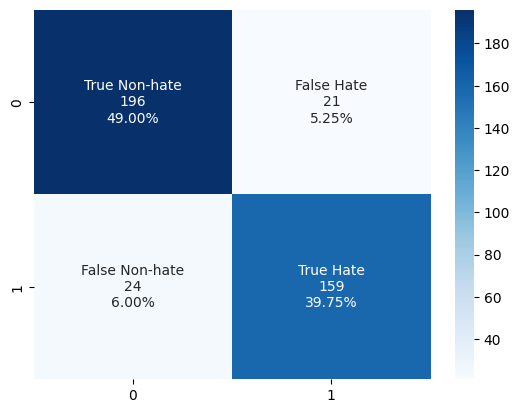

In [ ]:
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

# Graph train loss and val loss

In [ ]:
import matplotlib.pyplot as plt
from numpy import arange
from pickle import dump
from pickle import load
from matplotlib.pylab import plt
from numpy import arange

In [ ]:
with open('./train_loss.pkl', 'wb') as file:
    dump(train_loss_dict, file)

# Save the validation loss values
with open('./val_loss.pkl', 'wb') as file:
    dump(val_loss_dict, file)

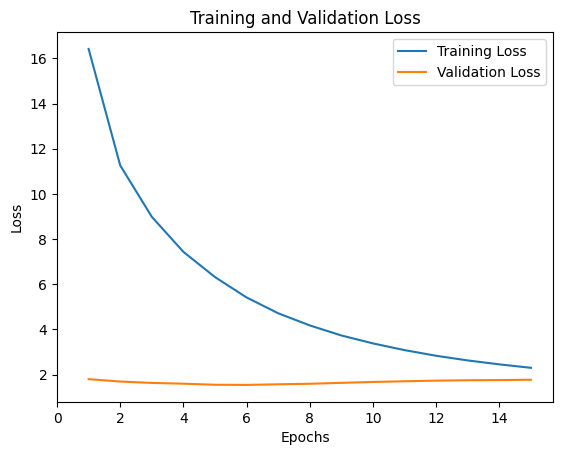

In [ ]:
train_loss = load(open('train_loss.pkl', 'rb'))
val_loss = load(open('val_loss.pkl', 'rb'))
train_values = train_loss.values()
val_values = val_loss.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 16)

# Plot and label the training and validation loss values
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 16, 2))

# Display the plot
plt.legend(loc='best')
plt.show()

# save  model

In [ ]:
import pickle

# Save the Tokenizer and the Model in the same file
with open('/content/drive/MyDrive/Lecture/NLP/indobert-finetuned-election-hatespeech/model_and_tokenizer.pkl', 'wb') as file:
  pickle.dump((tokenizer, model), file)

In [ ]:
# model.save_pretrained("/content/drive/MyDrive/Lecture/NLP/indobert-finetuned-election-hatespeech/model.pkl")
# tokenizer.save_pretrained("/content/drive/MyDrive/Lecture/NLP/indobert-finetuned-election-hatespeech/tokenizer")